Build a model that can rate the sentiment of a Tweet based on its content.

You'll build an NLP model to analyze Twitter sentiment about Apple and Google products. The dataset comes from CrowdFlower via data.world. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither.

Aim for a Proof of Concept There are many approaches to NLP problems - start with something simple and iterate from there. For example, you could start by limiting your analysis to positive and negative Tweets only, allowing you to build a binary classifier. Then you could add in the neutral Tweets to build out a multiclass classifier. You may also consider using some of the more advanced NLP methods in the Mod 4 Appendix.

Evaluation Evaluating multiclass classifiers can be trickier than binary classifiers because there are multiple ways to mis-classify an observation, and some errors are more problematic than others. Use the business problem that your NLP project sets out to solve to inform your choice of evaluation metrics.

Data: https://data.world/crowdflower/brands-and-product-emotions

# Business Understanding

In [1]:
!pip install catboost

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
# nltk related imports
import nltk
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [4]:
!ls ../../data

judge-1377884607_tweet_product_company.csv


In [5]:
df = pd.read_csv('../../data/judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
first_tweet = df['tweet_text'][0]
first_tweet

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [8]:
#lowercase
first_tweet_lower = first_tweet.lower()
first_tweet_lower

'.@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead!  i need to upgrade. plugin stations at #sxsw.'

In [9]:
#tweet tokenizer
tweet_tknzr = TweetTokenizer(strip_handles=True)
first_tweet_lower_tt = tweet_tknzr.tokenize(first_tweet_lower)
first_tweet_lower_tt

['.',
 'i',
 'have',
 'a',
 '3g',
 'iphone',
 '.',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#rise_austin',
 ',',
 'it',
 'was',
 'dead',
 '!',
 'i',
 'need',
 'to',
 'upgrade',
 '.',
 'plugin',
 'stations',
 'at',
 '#sxsw',
 '.']

In [10]:
#turn tokenized words back into tweet
first_tweet_lower_tweet = " ".join(first_tweet_lower_tt)
first_tweet_lower_tweet

'. i have a 3g iphone . after 3 hrs tweeting at #rise_austin , it was dead ! i need to upgrade . plugin stations at #sxsw .'

In [11]:
#use regexptokenizer
pattern = r"(?u)\w{2,}" # select all words with 2 or more characters
         #r"(?u)\b\w\w+\b"
         #r'\w+'     <-REMOVES PUNCTUATION
regexp_tknzr = RegexpTokenizer(pattern)
first_tweet_regexp = regexp_tknzr.tokenize(first_tweet_lower_tweet)
first_tweet_regexp

['have',
 '3g',
 'iphone',
 'after',
 'hrs',
 'tweeting',
 'at',
 'rise_austin',
 'it',
 'was',
 'dead',
 'need',
 'to',
 'upgrade',
 'plugin',
 'stations',
 'at',
 'sxsw']

In [12]:
# create list of stopwords in English
stopwords_list = stopwords.words('english')

#remove stopwords
first_tweet_sw_removed = [word for word in first_tweet_regexp if word not in stopwords_list]
first_tweet_sw_removed

['3g',
 'iphone',
 'hrs',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw']

In [13]:
# create lemma object
lemma = WordNetLemmatizer()
first_tweet_lemma = [lemma.lemmatize(token) for token in first_tweet_sw_removed]
first_tweet_lemma

['3g',
 'iphone',
 'hr',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station',
 'sxsw']

# Data Engineering/Prepping

In [14]:
df = df.rename(columns = {'tweet_text': 'Tweet', 
                         'emotion_in_tweet_is_directed_at': 'Product', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'})
df.head() #Sanity Check

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [15]:
df.shape

(9093, 3)

In [16]:
df['Tweet'].iloc[9092]

'\x8cÏ¡\x8eÏà\x8aü_\x8b\x81Ê\x8b\x81Î\x8b\x81Ò\x8b\x81£\x8b\x81Á\x8bââ\x8b\x81_\x8b\x81£\x8b\x81\x8f\x8bâ_\x8bÛâRT @mention Google Tests \x89ÛÏCheck-in Offers\x89Û\x9d At #SXSW {link}'

In [17]:
df['Tweet'].iloc[6]

nan

In [18]:
df.drop([6, 9092], inplace=True)
df.drop_duplicates(inplace=True)
df['Tweet'].dropna(inplace=True)

In [19]:
df.isna().sum()

Tweet           0
Product      5787
Sentiment       0
dtype: int64

In [20]:
df['Sentiment'].value_counts()

No emotion toward brand or product    5374
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: Sentiment, dtype: int64

In [21]:
df.Product.fillna("Undefined", inplace = True)
df["Product"].astype(str)

0                   iPhone
1       iPad or iPhone App
2                     iPad
3       iPad or iPhone App
4                   Google
               ...        
9087             Undefined
9088                  iPad
9089             Undefined
9090             Undefined
9091             Undefined
Name: Product, Length: 9069, dtype: object

In [22]:
df['Product'].value_counts()

Undefined                          5787
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: Product, dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9069 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9069 non-null   object
 1   Product    9069 non-null   object
 2   Sentiment  9069 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB


In [24]:
def find_brand(Product, Tweet): #Building function to determine Brand
    brand = 'Undetermined' #Labeling brand as Undetermined
    if ((Product.lower().__contains__('google')) or (Product.lower().__contains__('android'))): #Labeling Google
        brand = 'Google' #Unless tweet contains google or android
    elif ((Product.lower().__contains__('apple')) or (Product.lower().__contains__('ip'))): #Labeling Apple
        brand = 'Apple' #Unless tweet contains apple or ip
    
    if (brand == 'Undetermined'): 
        lower_tweet = Tweet.lower() #Making tweet lowercase
        is_google = (lower_tweet.__contains__('google')) or (lower_tweet.__contains__('android')) #Undetermined google
        is_apple = (lower_tweet.__contains__('apple')) or (lower_tweet.__contains__('ip')) #Undetermined apple
        
        if (is_google and is_apple): #if it has both identifiers in the tweet
            brand = 'Both' #Labeling brand as both
        elif (is_google):
            brand = 'Google' #Labeling brand as Google
        elif (is_apple):
            brand = 'Apple' #Labeling brand as Apple
    
    return brand

df['Brand'] = df.apply(lambda x: find_brand(x['Product'], x['Tweet']), axis = 1) #Applying function to column
df['Brand'].value_counts() #Reviewing value counts of each class within brand

Apple           5361
Google          2756
Undetermined     739
Both             213
Name: Brand, dtype: int64

In [25]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x == "Positive emotion" else 0)

In [26]:
df.head()

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,Google


# Create an Apple and Google DataFrame

In [27]:
#Create a DataFrame of Tweets only about Apple
apple_df = df[df['Brand']=='Apple']
#Create a DataFrame of Tweets only about Google
google_df = df[df['Brand']=="Google"]

In [28]:
apple_df.head()

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,Apple
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Undefined,0,Apple


In [29]:
google_df.head()

,Tweet,Product,Sentiment,Brand
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,Google
7,"#SXSW is just starting, #CTIA is around the co...",Android,1,Google
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,1,Google
11,Find &amp; Start Impromptu Parties at #SXSW Wi...,Android App,1,Google
12,"Foursquare ups the game, just in time for #SXS...",Android App,1,Google


In [30]:
# X = apple_df[['Tweet']]
# y = apple_df['Sentiment']
# X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

# Doing 2 Train_Test_Splits on whole Dataset

Doing the train-test split before the Data Preprocessing prevents data leakage.

In [31]:
#Create the X DataFrame with only the tweets
X = df[['Tweet']]
#Create the y Series with only the sentiments, 1 for Positive, 0 for not Positive
y = df['Sentiment']
#First train test split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
#Second train test split
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

In [32]:
#Baseline Understanding
y_train.value_counts(normalize=True)

0    0.67636
1    0.32364
Name: Sentiment, dtype: float64

In [33]:
# #If we did a multi class
# dict_sent = {'No emotion toward brand or product':1, 
#              'Positive emotion':2,
#              'Negative emotion':0,
#              "I can't tell": 1}
# df['Sentiment'] = df['Sentiment'].map(dict_sent)

In [34]:
# #Preprocess targets
# y_train = y_train.apply(lambda x: 1 if x == "Positive emotion" else 0)
# y_val = y_val.apply(lambda x: 1 if x == "Positive emotion" else 0)
# y_test = y_test.apply(lambda x: 1 if x == "Positive emotion" else 0)

In [35]:
X_train.head()

,Tweet
2324,@mention Can we make you an iPhone case with T...
5632,RT @mention Come party down with @mention &amp...
1751,#winning #winning - just gave away 5 red mophi...
5799,RT @mention google &amp; facebook have an offi...
3339,Rumor of Google launching their new social net...


In [36]:
X_train.shape

(6121, 1)

In [37]:
X_val.shape

(2041, 1)

In [38]:
#Instantiate necessary tools
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
stopwords_list = stopwords.words("english")
stopwords_list.append("sxsw") #remove sxsw because it's the hashtag for the event
lemma = WordNetLemmatizer()
tweet_tknzr = TweetTokenizer(strip_handles=True)

In [39]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [40]:
def clean_tweets(text):
    #Use TweetTokenizer object to remove the handles from the Tweet
    #TweetTokenizer also puts each punctuation as it's own token
    no_handle = tweet_tknzr.tokenize(text)
    #Join the list of non-handle tokens back together
    tweet = " ".join(no_handle) 
    #remove http websites, hashtag sign, any words in curly brackets,
        #any words with ampersand in front, www dot com websites, links,
        #videos, and non-english characters
    clean = re.sub("(https?:\/\/\S+) \
                   |(#[A-Za-z0-9_]+) \
                   |(\{([a-zA-Z].+)\}) \
                   |(&[a-z]+;) \
                   |(www\.[a-z]?\.?(com)+|[a-z]+\.(com))\
                   |({link})\
                   |(\[video\])\
                   |([^\x00-\x7F]+\ *(?:[^\x00-\x7F]| )*)"," ", tweet)
    #Turn all the tokens lowercase
    lower = clean.lower()
    #Only include words with 3 or more characters
    token_list = tokenizer.tokenize(lower)
    #Remove stopwords
    stopwords_removed=[token for token in token_list if token not in stopwords_list]
    #Lemmatize the remaining word tokens
    lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
    #Turn the lemma list into a string for the Vectorizer
    cleaned_string = " ".join(lemma_list) 
    return cleaned_string

In [41]:
#Sanity Check
clean_tweets(X_train['Tweet'].iloc[0])

'make iphone case ttye time want show support'

In [42]:
#Apply our clean_tweets function to X_train, X_val, X_test
X_train['Tweet'] = X_train['Tweet'].apply(lambda x: clean_tweets(x))
X_val['Tweet'] = X_val['Tweet'].apply(lambda x: clean_tweets(x))
X_test['Tweet'] = X_test['Tweet'].apply(lambda x: clean_tweets(x))

C:\Users\david\AppData\Local\Temp/ipykernel_51772/1064438169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Tweet'] = X_train['Tweet'].apply(lambda x: clean_tweets(x))
C:\Users\david\AppData\Local\Temp/ipykernel_51772/1064438169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['Tweet'] = X_val['Tweet'].apply(lambda x: clean_tweets(x))
C:\Users\david\AppData\Local\Temp/ipykernel_51772/1064438169.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [43]:
#Sanity Check
X_train

,Tweet
2324,make iphone case ttye time want show support
5632,come party google tonight link band food art i...
1751,winning winning gave away red mophie juice pac...
5799,google facebook official death policy vast maj...
3339,rumor google launching new social network call...
...,...
5702,even security guard austin enjoy ipad time link
8604,attending want explore austin check austin lin...
7836,apple popup store link gonnagetanipad2
7504,putting pop apple store smart talk understandi...


In [44]:
X_val

,Tweet
891,hootsuite mobile update iphone blackberry andr...
4198,morning hearing google circle today link
2164,great location choice nice timing ipad launch ...
1885,win ipad via link
4700,launching product plenty else join h4ckers 80 ...
...,...
1033,racing around best fueling great local fare ea...
4186,omg still line new ipad dieing hunger else line
7735,hour popup apple store lone security guard enj...
8211,great app interface example moma target flipbo...


In [45]:
#Sanity Check
y_train

2324    0
5632    1
1751    0
5799    0
3339    0
       ..
5702    1
8604    0
7836    0
7504    1
3536    0
Name: Sentiment, Length: 6121, dtype: int64

In [46]:
y_val

891     0
4198    0
2164    1
1885    1
4700    0
       ..
1033    0
4186    1
7735    0
8211    1
4517    0
Name: Sentiment, Length: 2041, dtype: int64

In [47]:
#DON'T NEED BECAUSE I ADDED A LINE TO THE CLEAN_TWEETS FUNCTION

# X_train["Tweet"] = X_train["Tweet"].str.join(" ")
# X_val["Tweet"] = X_val["Tweet"].str.join(" ")
# X_test["Tweet"] = X_test["Tweet"].str.join(" ")

In [48]:
#X_train.head()

# Vectorize

In [49]:
# Import the relevant vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [50]:
c_vectorizer = CountVectorizer()
c_vectorizer.fit(X_train['Tweet'])
X_train_c_vec = c_vectorizer.transform(X_train['Tweet'])
X_train_c_vec

<6121x7144 sparse matrix of type '<class 'numpy.int64'>'
	with 56927 stored elements in Compressed Sparse Row format>

In [51]:
X_train_c_vec_df = pd.DataFrame(X_train_c_vec.toarray(), columns=c_vectorizer.get_feature_names(), 
                              index=X_train.index)
X_train_c_vec_df

,000,0310apple,100,1000,101,106,10am,10pm,10x,10x2,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
2324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5632,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8604,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# #Sanity Check
# X_train_c_vec_df['sxsw']

In [53]:
X_val_c_vec = c_vectorizer.transform(X_val['Tweet'])
X_val_c_vec_df = pd.DataFrame(X_val_c_vec.toarray())

In [54]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train['Tweet'])
X_train_tfidf_vec = tfidf_vectorizer.transform(X_train['Tweet'])
X_val_tfidf_vec = tfidf_vectorizer.transform(X_val['Tweet'])
X_train_tfidf_vec_df = pd.DataFrame(X_train_tfidf_vec.toarray())
X_val_tfidf_vec_df = pd.DataFrame(X_val_tfidf_vec.toarray())
X_train_tfidf_vec_df.shape

(6121, 7144)

# Simple Logistic Regression Model w/ Count Vectorizer

In [55]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train_c_vec_df, y_train)
print(lr.score(X_train_c_vec_df, y_train))
print(lr.score(X_val_c_vec_df, y_val))

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8923378532919458
0.7403233708966193


# Simple Logistic Regression Model w/ Tfidf Vectorizer

In [56]:
lr_2 = LogisticRegression()
lr_2.fit(X_train_tfidf_vec_df, y_train)
print(lr_2.score(X_train_tfidf_vec_df, y_train))
print(lr_2.score(X_val_tfidf_vec_df, y_val))

0.7988890704133311
0.7295443410093092


# Naive Bayes w/ Count Vectorizer

In [57]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_c_vec_df, y_train)
print(naive_bayes.score(X_train_c_vec_df, y_train))
print(naive_bayes.score(X_val_c_vec_df, y_val))

0.857049501715406
0.7143557079862812


# Naive Bayes w/ Tfidf Vectorizer

In [58]:
naive_bayes_2 = MultinomialNB()
naive_bayes_2.fit(X_train_tfidf_vec_df, y_train)
print(naive_bayes_2.score(X_train_tfidf_vec_df, y_train))
print(naive_bayes_2.score(X_val_tfidf_vec_df, y_val))

0.7903937265152753
0.7128858402743753


# Naive Bayes w/ Tuned Vectorizers

In [215]:
c_vectorizer_2 = CountVectorizer(max_df=.99,min_df=.003, max_features=1000)
    #max_df=.95,  # removes words that appear in more than 95% of docs
    #min_df=2     # removes words that appear 2 or fewer times
c_vectorizer_2.fit(X_train['Tweet'])
X_train_c_vec_2 = c_vectorizer_2.transform(X_train['Tweet'])
X_val_c_vec_2 = c_vectorizer_2.transform(X_val['Tweet'])
X_train_c_vec_df_2 = pd.DataFrame(X_train_c_vec_2.toarray())
X_val_c_vec_df_2 = pd.DataFrame(X_val_c_vec_2.toarray())

In [216]:
naive_bayes_3 = MultinomialNB(alpha=.1)
naive_bayes_3.fit(X_train_c_vec_df_2, y_train)
print("naive bayes with tuned count vectorizer")
print(naive_bayes_3.score(X_train_c_vec_df_2, y_train))
print(naive_bayes_3.score(X_val_c_vec_df_2, y_val))

naive bayes with tuned count vectorizer
0.7319065512171213
0.7109260166585007


In [192]:
#WHOLE DATASET
# naive bayes with tuned count vectorizer
# 0.7582094429014867
# 0.705046545810877

In [186]:
tfidf_vectorizer_2 = TfidfVectorizer(max_df=.99,min_df=0.005, max_features=1000)
tfidf_vectorizer_2.fit(X_train['Tweet'])
X_train_tfidf_vec_2 = tfidf_vectorizer_2.transform(X_train['Tweet'])
X_val_tfidf_vec_2 = tfidf_vectorizer_2.transform(X_val['Tweet'])
X_train_tfidf_vec_df_2 = pd.DataFrame(X_train_tfidf_vec_2.toarray())
X_val_tfidf_vec_df_2 = pd.DataFrame(X_val_tfidf_vec_2.toarray())

In [187]:
naive_bayes_4 = MultinomialNB()
naive_bayes_4.fit(X_train_tfidf_vec_df_2, y_train)
print("naive bayes with tuned tfidf")
print(naive_bayes_4.score(X_train_tfidf_vec_df_2, y_train))
print(naive_bayes_4.score(X_val_tfidf_vec_df_2, y_val))

naive bayes with tuned tfidf
0.7162228394053259
0.7011268985791279


In [195]:
#WHOLE DATASET
# naive bayes with tuned tfidf
# 0.7162228394053259
# 0.7011268985791279

In [137]:
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from mlxtend.feature_selection import ColumnSelector
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_auc_score, plot_confusion_matrix

In [66]:
#evaluate function
def evaluate(estimator, X_tr, X_te, y_tr, y_te, roc_auc='skip'):
    '''
    orginial function at : 
    (https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb)
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score
    
    Inputs:
        estimator: a fit sklearn-style model or pipeline
        X_tr: array or pandas dataframe
            training input variables
        X_te: array or pandas dataframe
            testing input variables
        y_tr: array or pandas series
            training output variable
        y_te: array or pandas series
            testing output variable
        roc_auc: str
            'skip': default, skips calculating roc_auc
            'dec': use decision_function to calculate roc_auc
            'proba': use predict_proba to calculate roc_auc
            
    '''
    # Grab predictions
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")    
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_te, y_te, values_format='.5g', cmap=plt.cm.Oranges)

In [217]:
nb_tuned = Pipeline(steps=[
    ('col_selector', ColumnSelector(cols=('Tweet'),drop_axis=True)),
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [223]:
param_grid = {
    "tfidf__max_df" : [.99],
    "tfidf__min_df" : [.0003,],
    "tfidf__max_features" : [1000],
    'clf__alpha': [.1]
}

In [224]:
grid = GridSearchCV(nb_tuned, param_grid, scoring = "recall", return_train_score=True)

In [225]:
output = grid.fit(X_train, y_train)

In [226]:
output.best_params_

{'clf__alpha': 0.1,
 'tfidf__max_df': 0.99,
 'tfidf__max_features': 1000,
 'tfidf__min_df': 0.0003}

Training Scores:
Train Accuracy: 0.7647443228230681
Train Precision: 0.775178026449644
Train Recall: 0.38465421504290764
Train F1-Score: 0.51417004048583
ROC-AUC: 0.8094020611265963
**********
Testing Scores:
Test Accuracy: 0.7138657520823126
Test Precision: 0.653179190751445
Test Recall: 0.32753623188405795
Test F1-Score: 0.43629343629343625
ROC-AUC: 0.7214426377398345


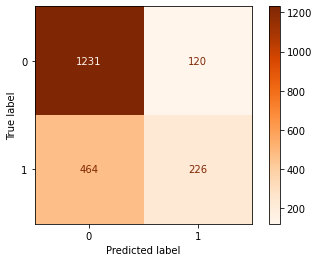

In [227]:
evaluate(output.best_estimator_, X_train, X_val, y_train, y_val, roc_auc='proba')

# Logistic Regression with max iter = 1000

In [196]:
lr_3 = LogisticRegression(max_iter=1000)
lr_3.fit(X_train_c_vec_df, y_train)
print("default count vectorizer")
print(lr_3.score(X_train_c_vec_df, y_train))
print(lr_3.score(X_val_c_vec_df, y_val))

default count vectorizer
0.900497512437811
0.6990049751243781


In [197]:
#lr_3 = LogisticRegression(max_iter=1000)
lr_3.fit(X_train_tfidf_vec_df, y_train)
print("default tfidf vectorizer")
print(lr_3.score(X_train_tfidf_vec_df, y_train))
print(lr_3.score(X_val_tfidf_vec_df, y_val))

default tfidf vectorizer
0.8228302929795467
0.6965174129353234


In [198]:
#lr_3 = LogisticRegression(max_iter=1000)
lr_3.fit(X_train_tfidf_vec_df_2, y_train)
print("tfidf vectorizer with tuned parameters")
print(lr_3.score(X_train_tfidf_vec_df_2, y_train))
print(lr_3.score(X_val_tfidf_vec_df_2, y_val))

tfidf vectorizer with tuned parameters
0.7252625760088447
0.6824212271973465


# PCA w/ Logistic Regression

In [199]:
#Import necessary tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [200]:
#Create a StandardScaler Object
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_c_vec_df) #Use default count vectorizer
X_val_scaled = scaler.transform(X_val_c_vec_df)

In [201]:
# Code to import, instantiate and fit a PCA object
pca = PCA(n_components = .95, random_state=42)
pca.fit(X_train_scaled)
pca.n_components_

1844

In [202]:
from sklearn.pipeline import Pipeline
# Construct a pipelines
pipe_lr = Pipeline([('pca', pca), 
                    ('lr', LogisticRegression(random_state=42, max_iter=1000))])
pipe_lr.fit(X_train_scaled, y_train)
print("PCA with n_components=0.95, default count vectorizer, and logistic regression")
print(pipe_lr.score(X_train_scaled, y_train))
print(pipe_lr.score(X_val_scaled, y_val))

PCA with n_components=0.95, default count vectorizer, and logistic regression
0.9494195688225538
0.6799336650082919


In [204]:
# pipe_mnb = Pipeline([('pca', pca), 
#                     ('mnb', MultinomialNB())])
# pipe_mnb.fit(X_train_scaled, y_train)
# print("PCA with n_components=0.95, default count vectorizer, and naive bayes")
# print(pipe_lr.score(X_train_scaled, y_train))
# print(pipe_lr.score(X_val_scaled, y_val))

*I got an error about MultinomialNB not having negative values*

# PCA w/ Tuned TFIDF Vectorizer

In [205]:
#Import necessary tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [206]:
#Create a StandardScaler Object
scaler = StandardScaler()

#Fit scaler to tuned vectorized X_train and transform both X_train and X_val
X_train_scaled = scaler.fit_transform(X_train_tfidf_vec_df_2)
X_val_scaled = scaler.transform(X_val_tfidf_vec_df_2)

In [207]:
#Create a PCA object
pca = PCA(n_components = .99, random_state=42)

In [208]:
pca.fit(X_train_scaled)
pca.n_components_

265

In [209]:
#Create a Pipeline object for PCA and Logistic Regression
pipe_lr = Pipeline([('pca', pca), 
                    ('lr', LogisticRegression(random_state=42, max_iter=1000))])
pipe_lr.fit(X_train_scaled, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.99, random_state=42)),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])

In [210]:
#Check results
print("PCA with n_components=0.99, tuned tfidf vectorizer, and naive bayes")
print(pipe_lr.score(X_train_scaled, y_train))
print(pipe_lr.score(X_val_scaled, y_val))

PCA with n_components=0.99, tuned tfidf vectorizer, and naive bayes
0.7252625760088447
0.681592039800995


In [211]:
# PCA with n_components=0.99, tuned tfidf vectorizer, and naive bayes
# 0.7250449272994609
# 0.7099461048505634

# Pipeline and Cross Validate

In [156]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier

In [157]:
pipe_logreg = Pipeline(steps=[
    ('count_vectorizer', CountVectorizer()),
    ('logreg', LogisticRegression(random_state=42))
])
cv = cross_validate(pipe_logreg, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'precision','roc_auc'])
cv

/Users/garrettwilliams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/garrettwilliams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

{'fit_time': array([0.14137435, 0.14024305, 0.138978  , 0.13517618, 0.13740969]),
 'score_time': array([0.01971579, 0.01860189, 0.01813698, 0.01784301, 0.01842141]),
 'test_accuracy': array([0.74040816, 0.71486928, 0.75571895, 0.71405229, 0.73856209]),
 'train_accuracy': array([0.90012255, 0.90095977, 0.8989177 , 0.90300184, 0.90014294]),
 'test_precision': array([0.64468864, 0.58545455, 0.68301887, 0.5777027 , 0.64393939]),
 'train_precision': array([0.93008641, 0.93035994, 0.92182663, 0.93977813, 0.9335443 ]),
 'test_roc_auc': array([0.76039043, 0.72168393, 0.75111928, 0.72181965, 0.72928713]),
 'train_roc_auc': array([0.9658115 , 0.96702756, 0.96351533, 0.96518872, 0.96585212])}

# Pipeline for Naive Bayes w/ Default Vectorizer

In [158]:
#Create a pipeline to use an Untuned TfidfVectorizer() and MultinomialNB()
pipe_nb = Pipeline(steps=[
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('nb', MultinomialNB())
])
#Cross validate
cv = cross_validate(pipe_nb, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
#See the results
cv

{'fit_time': array([0.0408442 , 0.03933597, 0.03985906, 0.03992701, 0.04186916]),
 'score_time': array([0.01813602, 0.01813412, 0.01827288, 0.01857829, 0.01944375]),
 'test_accuracy': array([0.70612245, 0.70506536, 0.69934641, 0.69444444, 0.70915033]),
 'train_accuracy': array([0.78696895, 0.7945681 , 0.78742087, 0.79252604, 0.79048397]),
 'test_recall': array([0.15365239, 0.14646465, 0.12626263, 0.13636364, 0.16161616]),
 'train_recall': array([0.35669192, 0.38170347, 0.35772871, 0.37223975, 0.36719243]),
 'test_roc_auc': array([0.73155094, 0.6767448 , 0.69595411, 0.70236178, 0.70092379]),
 'train_roc_auc': array([0.88950838, 0.89780161, 0.89179296, 0.89564979, 0.89119786])}

In [159]:
#Get mean accuracy for validation set
cv['test_accuracy'].mean()

0.7028257969854609

# Pipeline for Naive Bayes w/ Tuned Vectorizer

In [160]:
#Create a pipeline to use an Tuned TfidfVectorizer() and MultinomialNB()
pipe_nb_tuned = Pipeline(steps=[
    ('tfidf_vectorizer_tuned', TfidfVectorizer(max_df=.99,min_df=0.005, max_features=1000)),
    ('nb_tuned', MultinomialNB())
])
#Cross validate
cv = cross_validate(pipe_nb_tuned, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
#See the results
cv

{'fit_time': array([0.04241419, 0.04056215, 0.03925681, 0.03921103, 0.039891  ]),
 'score_time': array([0.01800704, 0.01839113, 0.01804519, 0.01959586, 0.01807213]),
 'test_accuracy': array([0.71265306, 0.7001634 , 0.70588235, 0.68954248, 0.70343137]),
 'train_accuracy': array([0.71486928, 0.71880743, 0.71554013, 0.7177864 , 0.71860323]),
 'test_recall': array([0.19647355, 0.18181818, 0.16414141, 0.17676768, 0.16666667]),
 'train_recall': array([0.19318182, 0.20694006, 0.18927445, 0.21514196, 0.20315457]),
 'test_roc_auc': array([0.69983816, 0.65763309, 0.68208352, 0.66534762, 0.6631487 ]),
 'train_roc_auc': array([0.72634787, 0.73428142, 0.72852908, 0.73547677, 0.73252431])}

# Pipeline for Random Forest Classifier

In [188]:
pipe_rfc = Pipeline(steps=[
    ('tfidf_vectorizer', TfidfVectorizer(max_df=.99,min_df=0.005, max_features=1000)),
    ('rfc', RandomForestClassifier(random_state=42))
])
cv = cross_validate(pipe_rfc, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'precision','roc_auc'])
cv

{'fit_time': array([1.35563898, 1.32724214, 1.3579073 , 1.32797313, 1.31642294]),
 'score_time': array([0.09072995, 0.08811212, 0.09062457, 0.0879178 , 0.08778   ]),
 'test_accuracy': array([0.71510204, 0.71568627, 0.71650327, 0.72058824, 0.70915033]),
 'train_accuracy': array([0.95118464, 0.94853992, 0.94894834, 0.94813151, 0.94935675]),
 'test_precision': array([0.59677419, 0.59022556, 0.59760956, 0.608     , 0.57936508]),
 'train_precision': array([0.96030116, 0.95997239, 0.96450939, 0.95676047, 0.96650384]),
 'test_roc_auc': array([0.71998169, 0.71112087, 0.70720185, 0.71120474, 0.70237856]),
 'train_roc_auc': array([0.99131925, 0.99003833, 0.99008938, 0.98925492, 0.98986803])}

# Grid Search for Random Forest Classifier

In [195]:
pg_rfc = {
    "rfc__max_depth" :[25, 50, 100],
    "rfc__min_samples_leaf" : [1, 3, 5],
    "rfc__n_estimators": [500, 1000, 1500],
    "rfc__class_weight" :['balanced'],
    "rfc__random_state":[42]
}
grid_rfc = GridSearchCV(estimator = pipe_rfc, param_grid=pg_rfc, scoring='accuracy',
                        return_train_score = True)
grid_rfc.fit(X_train['Tweet'], y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf_vectorizer',
                                        TfidfVectorizer(max_df=0.99,
                                                        max_features=1000,
                                                        min_df=0.005)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rfc__class_weight': ['balanced'],
                         'rfc__max_depth': [25, 50, 100],
                         'rfc__min_samples_leaf': [1, 3, 5],
                         'rfc__n_estimators': [500, 1000, 1500],
                         'rfc__random_state': [42]},
             scoring='accuracy')

In [196]:
pd.DataFrame(grid_rfc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__class_weight,param_rfc__max_depth,param_rfc__min_samples_leaf,param_rfc__n_estimators,param_rfc__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.318658,0.058411,0.104045,0.008570,balanced,25,1,500,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.703673,0.692810,0.695261,0.693627,0.676471,0.692369,0.008840,9
1,4.573491,0.096270,0.190555,0.002927,balanced,25,1,1000,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.702041,0.691176,0.698529,0.695261,0.680556,0.693513,0.007407,8
2,6.840107,0.197343,0.282089,0.002942,balanced,25,1,1500,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.701224,0.687092,0.702614,0.695261,0.681373,0.693513,0.008173,7
3,1.624615,0.020397,0.093181,0.001943,balanced,25,3,500,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.686531,0.678105,0.681373,0.682190,0.658497,0.677339,0.009797,18
4,3.238793,0.054916,0.177897,0.002050,balanced,25,3,1000,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.692245,0.673203,0.687092,0.683824,0.662582,0.679789,0.010623,16
5,4.739683,0.064339,0.270101,0.023248,balanced,25,3,1500,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.693061,0.670752,0.687092,0.686275,0.661765,0.679789,0.011646,17
6,1.456939,0.015529,0.089320,0.000478,balanced,25,5,500,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.679184,0.667484,0.678105,0.678105,0.661765,0.672928,0.007028,27
7,2.861272,0.034160,0.169892,0.002214,balanced,25,5,1000,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.683265,0.665033,0.687092,0.673203,0.660131,0.673745,0.010299,24
8,4.256708,0.030177,0.247809,0.001791,balanced,25,5,1500,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.684898,0.660948,0.688725,0.674837,0.659314,0.673744,0.012017,25
9,4.277533,0.067883,0.135058,0.000474,balanced,50,1,500,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.706939,0.705065,0.710784,0.709967,0.698529,0.706257,0.004379,2


In [197]:
grid_rfc.best_params_

{'rfc__class_weight': 'balanced',
 'rfc__max_depth': 50,
 'rfc__min_samples_leaf': 1,
 'rfc__n_estimators': 1000,
 'rfc__random_state': 42}